/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_80657/338409594.py:242: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  beta_abs = beta_t.abs().fillna(method='ffill').fillna(1.0)


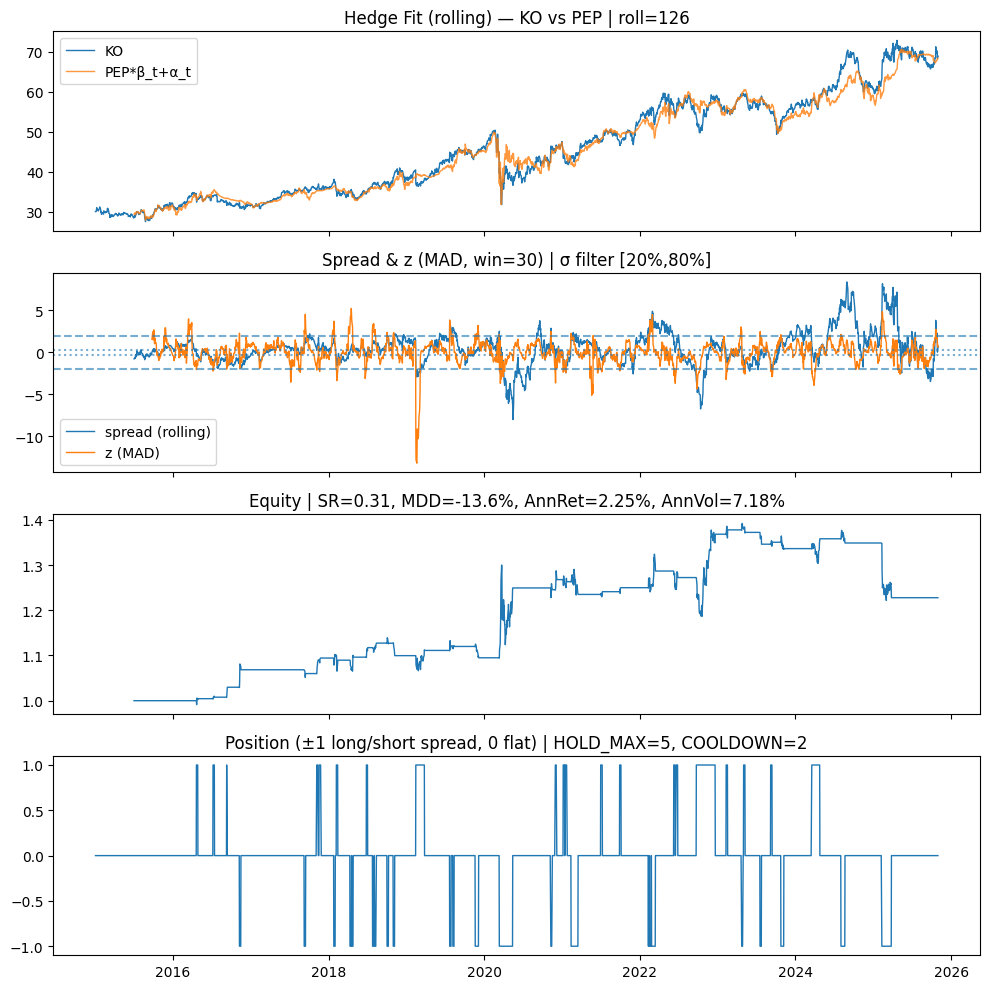

=== Pairs summary (sorted by Sharpe) ===


,A,B,Sharpe,AnnRet,AnnVol,MaxDD,HalfLife_d,Trades,HitRate
0,KO,PEP,0.312905,0.022462,0.071785,-0.13555,497.527413,43,0.367067


=== EW Portfolio across 1 pairs ===
Sharpe=0.31 | MaxDD=-13.6% | AnnRet=2.25% | AnnVol=7.18%


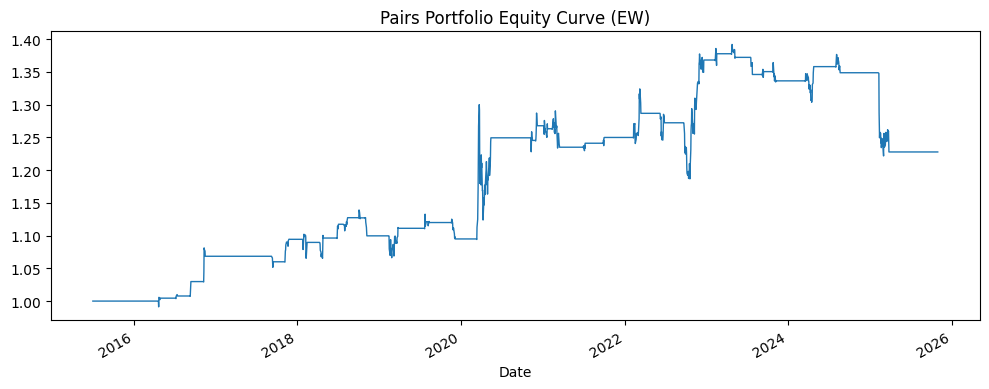

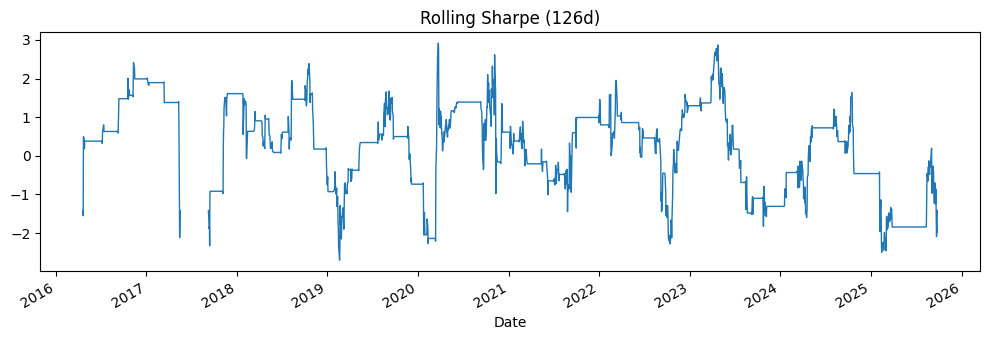

In [20]:
# Mean Reversion — 03_pairs_trading (improved)
# yfinance data only; nothing saved to disk.
# Features: cointegration filter, rolling OLS (alpha,beta), MAD z-scores, soft exit, time-stop, cooldown, vol filter.

from __future__ import annotations
import itertools
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import yfinance as yf

# =====================
# Config (edit freely)
# =====================
TICKERS = ['KO', 'PEP']
# TICKERS = ['MS', 'GS']
# TICKERS = ['0939.HK','1288.HK','1398.HK','3988.HK']  
START   = '2015-01-01'
END     = None          # None = to today
AUTO_ADJUST = False     # use Adj Close from yfinance

# Pair pre-selection by correlation
CORR_LOOKBACK = 252
TOP_N_PAIRS_BY_CORR = 10

# Stationarity checks
REQUIRE_COINTEGRATION = False
COINT_ALPHA = 0.05          # Engle–Granger p-value threshold
REQUIRE_HALFLIFE_MAX = None   # days; require HL < this (set None to disable)

# Rolling hedge ratio (alpha, beta)
ROLL_WIN = 126              # 60–126 typical; smaller = more responsive
MIN_SAMPLES = 260           # skip pairs with too-short history

# Trading parameters
ZS_WIN     = 30             # z-window on spread; short (20–30) for faster edges
Z_ENTRY    = 2.0            # enter if |z| > Z_ENTRY
Z_EXIT     = 0.3            # soft exit when |z| < Z_EXIT (or time-stop)
HOLD_MAX   = 5              # time-stop (days)
COOLDOWN   = 2              # days after close before another entry
TC_BPS     = 5              # round-trip cost in bps on both legs, scaled by (1+|beta_t|)

# Volatility regime filter on spread sigma (avoid extremes)
VOL_WIN = 30                # rolling std window on spread
SIGMA_Q_LOW, SIGMA_Q_HIGH = 0.2, 0.8  # trade only if sigma in middle quantiles

SHOW_PLOTS = True
PDAYS = 252

# ==============
# Helper funcs
# ==============
def sharpe_ann(r, periods=252):
    r = r.dropna()
    s = r.std(ddof=0)
    if s == 0 or np.isnan(s):
        return np.nan
    return r.mean() * periods / (s * np.sqrt(periods))

def max_drawdown(eq: pd.Series):
    peak = eq.cummax()
    dd = eq / peak - 1.0
    return float(dd.min())

def mad_z(x: pd.Series, win: int):
    """Robust z: (x - rolling_median)/(1.4826*rolling_MAD)."""
    med = x.rolling(win, min_periods=win).median()
    dev = (x - med).abs()
    mad = dev.rolling(win, min_periods=win).median()
    z = (x - med) / (1.4826 * mad.replace(0, np.nan))
    return z

def half_life(spread: pd.Series):
    s = spread.dropna()
    if len(s) < 100: return np.nan
    y = s.iloc[1:].values
    x = s.shift(1).iloc[1:].values
    X = sm.add_constant(x)
    try:
        phi = sm.OLS(y, X).fit().params[1]
        if phi <= 0 or phi >= 1: return np.nan
        return -np.log(2) / np.log(phi)
    except Exception:
        return np.nan

def rolling_ols_alpha_beta(a: pd.Series, b: pd.Series, win: int) -> Tuple[pd.Series, pd.Series]:
    """Return rolling alpha_t, beta_t where a_t ~ alpha + beta * b_t (OLS over last 'win' obs)."""
    idx = a.index.intersection(b.index)
    a, b = a.loc[idx], b.loc[idx]
    alpha = pd.Series(index=idx, dtype=float)
    beta  = pd.Series(index=idx, dtype=float)

    # Efficient rolling OLS via cumulative sums (y on x)
    # For windowed OLS: beta = Cov(x,y)/Var(x), alpha = mean(y) - beta*mean(x)
    x = b.astype(float)
    y = a.astype(float)

    # Precompute rolling means
    mean_x = x.rolling(win, min_periods=win).mean()
    mean_y = y.rolling(win, min_periods=win).mean()

    # Rolling cov and var
    cov_xy = (x*y).rolling(win, min_periods=win).mean() - mean_x*mean_y
    var_x  = (x*x).rolling(win, min_periods=win).mean() - mean_x*mean_x

    beta  = (cov_xy / var_x).replace([np.inf, -np.inf], np.nan)
    alpha = mean_y - beta * mean_x
    return alpha, beta

@dataclass
class PairResult:
    pair: Tuple[str, str]
    sharpe: float
    annret: float
    annvol: float
    mdd: float
    halflife: float
    trades: int
    hitrate: float
    equity: pd.Series
    ret: pd.Series

# ==========================
# 1) Download price data
# ==========================
raw = yf.download(TICKERS, start=START, end=END, auto_adjust=AUTO_ADJUST, progress=False)
prices = raw['Adj Close'].sort_index().ffill().dropna(how='all')
prices = prices.loc[:, prices.notna().sum() >= MIN_SAMPLES].dropna()

if prices.shape[1] < 2:
    raise RuntimeError("Need at least two tickers with sufficient data.")

# ==========================
# 2) Pair pre-selection
# ==========================
def top_corr_pairs(px: pd.DataFrame, lookback=CORR_LOOKBACK, topN=TOP_N_PAIRS_BY_CORR):
    if len(px) < lookback + 10:
        lookback = max(60, len(px)//3)
    corr = px.pct_change().rolling(lookback).corr().dropna()
    last_date = corr.index.get_level_values(0).max()
    corr_last = corr.xs(last_date)
    cands = []
    cols = list(corr_last.columns)
    for i, j in itertools.combinations(cols, 2):
        cands.append(((i, j), corr_last.loc[i, j]))
    cands.sort(key=lambda kv: kv[1], reverse=True)
    return [p for p, _ in cands[:topN]]

pairs = top_corr_pairs(prices)
if not pairs:
    pairs = list(itertools.combinations(list(prices.columns), 2))

# ==========================
# 3) Backtest a single pair
# ==========================
def backtest_pair(A: str, B: str) -> PairResult | None:
    df = prices[[A, B]].dropna()
    if df.shape[0] < max(ROLL_WIN, ZS_WIN) + 50:
        return None

    a, b = df[A], df[B]

    # ---- Static OLS for cointegration screening & baseline spread ----
    X = sm.add_constant(b.values)
    ols = sm.OLS(a.values, X, missing='drop').fit()
    alpha0, beta0 = float(ols.params[0]), float(ols.params[1])
    spread0 = a - alpha0 - beta0*b

    # Engle–Granger test
    if REQUIRE_COINTEGRATION:
        _, pval, _ = coint(a, b)
        if pval >= COINT_ALPHA:
            return None

    # Half-life screen (on static spread)
    hl0 = half_life(spread0)
    if (REQUIRE_HALFLIFE_MAX is not None) and (np.isnan(hl0) or hl0 > REQUIRE_HALFLIFE_MAX):
        return None

    # ---- Rolling hedge ratio (alpha_t, beta_t) ----
    alpha_t, beta_t = rolling_ols_alpha_beta(a, b, ROLL_WIN)
    # Spread with rolling coefficients
    spread = a - alpha_t - beta_t * b

    # ---- Robust z-score on spread (MAD) ----
    z = mad_z(spread, ZS_WIN)

    # ---- Volatility regime filter on spread ----
    sigma = spread.rolling(VOL_WIN, min_periods=VOL_WIN).std(ddof=0)
    qlow, qhigh = sigma.quantile(SIGMA_Q_LOW), sigma.quantile(SIGMA_Q_HIGH)
    tradable_sigma = (sigma >= qlow) & (sigma <= qhigh)

    # ---- Position logic with soft exit, time-stop, cooldown ----
    pos = pd.Series(0.0, index=df.index)
    state = 0
    hold = 0
    cooldown = 0
    for t, date in enumerate(df.index):
        zt = z.iat[t]
        tradable = tradable_sigma.iat[t] if not np.isnan(tradable_sigma.iat[t]) else False

        if np.isnan(zt) or (not tradable):
            pos.iat[t] = state
            if state != 0:
                # still holding but not tradable; count towards time-stop
                hold += 1
            if cooldown > 0:
                cooldown -= 1
            continue

        if state == 0:
            if cooldown == 0:
                if zt >  Z_ENTRY:
                    state, hold = -1, 1        # short spread
                elif zt < -Z_ENTRY:
                    state, hold = +1, 1        # long spread
            pos.iat[t] = state
        else:
            # soft exit or time-stop
            if (abs(zt) < Z_EXIT) or (hold >= HOLD_MAX):
                state, hold, cooldown = 0, 0, COOLDOWN
            else:
                hold += 1
            pos.iat[t] = state

        if cooldown > 0:
            cooldown -= 1

    # ---- PnL with rolling beta ----
    rA = a.pct_change().fillna(0.0)
    rB = b.pct_change().fillna(0.0)
    leg_ret = rA - (beta_t * rB)                 # long-spread payoff; sign handled by 'pos'
    gross = pos.shift(1).fillna(0.0) * leg_ret

    # Costs on both legs with rolling beta: |Δpos| * (1 + |beta_t|) * bps
    dpos = pos.diff().abs().fillna(0.0)
    beta_abs = beta_t.abs().fillna(method='ffill').fillna(1.0)
    tc = dpos * (1.0 + beta_abs) * (TC_BPS * 1e-4)

    strat_ret = gross - tc
    eq = (1 + strat_ret).cumprod()

    sr   = sharpe_ann(strat_ret)
    mdd  = max_drawdown(eq)
    annr = strat_ret.mean() * PDAYS
    annv = strat_ret.std(ddof=0) * np.sqrt(PDAYS)
    trades = int((dpos > 0).sum() / 2)
    hit = float((strat_ret[strat_ret != 0] > 0).mean()) if (strat_ret != 0).any() else np.nan

    if SHOW_PLOTS:
        fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
        axs[0].plot(df.index, a, lw=1, label=A)
        axs[0].plot(df.index, (beta_t*b + alpha_t), lw=1, label=f"{B}*β_t+α_t", alpha=0.8)
        axs[0].set_title(f"Hedge Fit (rolling) — {A} vs {B} | roll={ROLL_WIN}")
        axs[0].legend()

        axs[1].plot(df.index, spread, lw=1, label='spread (rolling)')
        axs[1].plot(df.index, z, lw=1, label='z (MAD)')
        axs[1].axhline(Z_ENTRY, ls='--', alpha=0.6)
        axs[1].axhline(-Z_ENTRY, ls='--', alpha=0.6)
        axs[1].axhline(Z_EXIT, ls=':', alpha=0.6)
        axs[1].axhline(-Z_EXIT, ls=':', alpha=0.6)
        axs[1].set_title(f"Spread & z (MAD, win={ZS_WIN}) | σ filter [{SIGMA_Q_LOW:.0%},{SIGMA_Q_HIGH:.0%}]")
        axs[1].legend()

        axs[2].plot(df.index, eq, lw=1)
        axs[2].set_title(f"Equity | SR={sr:.2f}, MDD={mdd:.1%}, AnnRet={annr:.2%}, AnnVol={annv:.2%}")

        axs[3].plot(df.index, pos, lw=1, label='pos')
        axs[3].set_title(f"Position (±1 long/short spread, 0 flat) | HOLD_MAX={HOLD_MAX}, COOLDOWN={COOLDOWN}")
        plt.tight_layout()
        plt.show()

    return PairResult(
        pair=(A, B),
        sharpe=float(sr),
        annret=float(annr),
        annvol=float(annv),
        mdd=float(mdd),
        halflife=float(hl0) if not np.isnan(hl0) else np.nan,
        trades=trades,
        hitrate=hit,
        equity=eq,
        ret=strat_ret
    )

# ==========================
# 4) Run over pairs
# ==========================
results: List[PairResult] = []
for A, B in pairs:
    try:
        out = backtest_pair(A, B)
        if out is not None:
            results.append(out)
    except Exception as e:
        print(f"[skip] {A}-{B}: {e}")

if not results:
    raise RuntimeError("No valid pairs after filters. Try relaxing COINT/HL filters or widen universe.")

summary = pd.DataFrame([{
    "A": r.pair[0], "B": r.pair[1],
    "Sharpe": r.sharpe, "AnnRet": r.annret, "AnnVol": r.annvol,
    "MaxDD": r.mdd, "HalfLife_d": r.halflife, "Trades": r.trades, "HitRate": r.hitrate
} for r in results]).sort_values("Sharpe", ascending=False)

print("=== Pairs summary (sorted by Sharpe) ===")
display(summary.head(10))

# ==========================
# 5) Simple EW portfolio
# ==========================
aligned = pd.concat([r.ret.rename(f"{r.pair[0]}-{r.pair[1]}") for r in results], axis=1).dropna(how="all")
port_ret = aligned.mean(axis=1).fillna(0.0)
port_eq  = (1 + port_ret).cumprod()

sr  = sharpe_ann(port_ret)
mdd = max_drawdown(port_eq)
ann = port_ret.mean() * PDAYS
vol = port_ret.std(ddof=0) * np.sqrt(PDAYS)

print(f"=== EW Portfolio across {aligned.shape[1]} pairs ===")
print(f"Sharpe={sr:.2f} | MaxDD={mdd:.1%} | AnnRet={ann:.2%} | AnnVol={vol:.2%}")

if SHOW_PLOTS:
    plt.figure(figsize=(10,4))
    port_eq.plot(lw=1)
    plt.title("Pairs Portfolio Equity Curve (EW)")
    plt.tight_layout()
    plt.show()

    roll = 126
    rs = (port_ret.rolling(roll).mean() / port_ret.rolling(roll).std(ddof=0)) * np.sqrt(PDAYS)
    plt.figure(figsize=(10,3.5))
    rs.plot(lw=1)
    plt.title("Rolling Sharpe (126d)")
    plt.tight_layout()
    plt.show()


<Axes: xlabel='Date'>

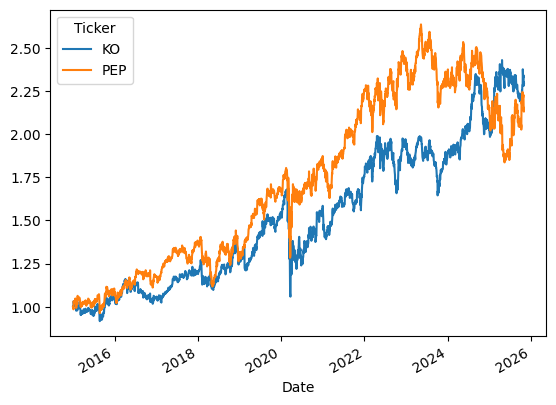

In [21]:
(prices / prices.iloc[0]).plot()


===== DAILY DATA =====
OLS beta: 4.428
ADF p-value (stationarity of spread): 0.2355
Cointegration p-value: 0.4641
Half-life: 393.41 dailys

===== WEEKLY DATA =====
OLS beta: 4.431
ADF p-value (stationarity of spread): 0.2037
Cointegration p-value: 0.4202
Half-life: 85.55 weeklys


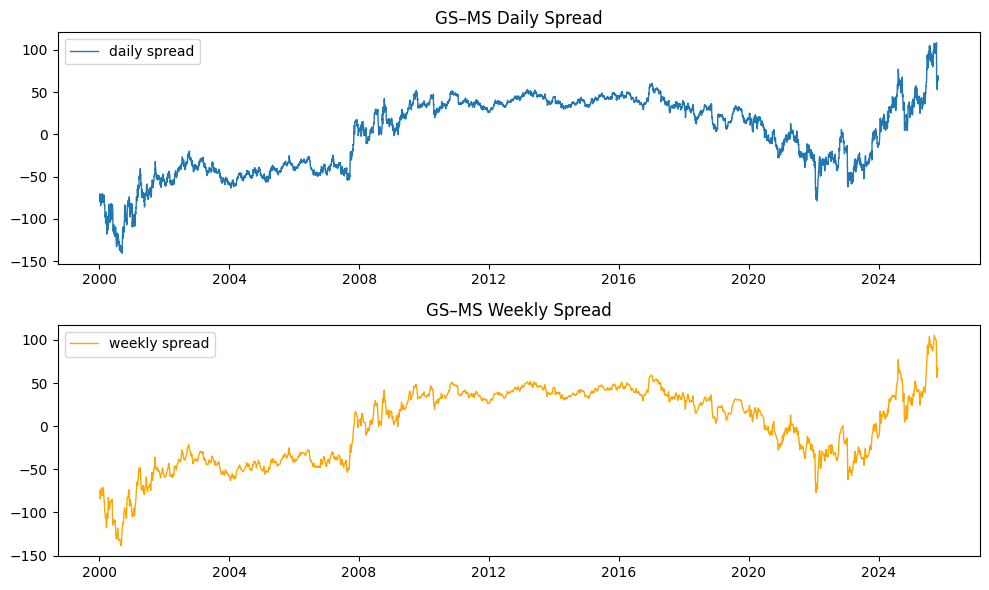

In [22]:
# Compare mean reversion (daily vs weekly)
from statsmodels.tsa.stattools import adfuller, coint

TICKERS = ['GS', 'MS']
START = '2000-01-01'
END = None

# Download daily prices
raw = yf.download(TICKERS, start=START, end=END, auto_adjust=False, progress=False)
prices_d = raw['Adj Close'].dropna().ffill()

# Resample weekly (Friday close)
prices_w = prices_d.resample('W-FRI').last().dropna()

# ---------- Helper functions ----------
def ols_spread(a, b):
    """Return alpha, beta, residual spread"""
    X = sm.add_constant(b)
    model = sm.OLS(a, X, missing='drop').fit()
    alpha, beta = model.params
    spread = a - alpha - beta*b
    return alpha, beta, spread

def adf_test(series):
    res = adfuller(series.dropna())
    return {"ADF Stat": res[0], "p-value": res[1]}

def half_life(spread):
    """Estimate mean reversion half-life from AR(1) fit."""
    s = spread.dropna()
    if len(s) < 30:
        return np.nan
    y = s[1:].values
    x = s[:-1].values
    X = sm.add_constant(x)
    phi = sm.OLS(y, X).fit().params[1]
    if phi <= 0 or phi >= 1:
        return np.nan
    return -np.log(2) / np.log(phi)

def show_summary(freq, a, b, prices):
    print(f"\n===== {freq.upper()} DATA =====")
    alpha, beta, spread = ols_spread(prices[a], prices[b])
    hl = half_life(spread)
    adf = adf_test(spread)
    _, p_coint, _ = coint(prices[a], prices[b])
    print(f"OLS beta: {beta:.3f}")
    print(f"ADF p-value (stationarity of spread): {adf['p-value']:.4f}")
    print(f"Cointegration p-value: {p_coint:.4f}")
    print(f"Half-life: {hl:.2f} {freq.lower()}s")
    return spread

# ---------- Run comparison ----------
spread_d = show_summary("daily",  TICKERS[0], TICKERS[1], prices_d)
spread_w = show_summary("weekly", TICKERS[0], TICKERS[1], prices_w)

# ---------- Visualization ----------
fig, axs = plt.subplots(2, 1, figsize=(10,6), sharex=False)
axs[0].plot(spread_d.index, spread_d, lw=1, label='daily spread')
axs[0].set_title(f"{TICKERS[0]}–{TICKERS[1]} Daily Spread")
axs[0].legend()

axs[1].plot(spread_w.index, spread_w, lw=1, color='orange', label='weekly spread')
axs[1].set_title(f"{TICKERS[0]}–{TICKERS[1]} Weekly Spread")
axs[1].legend()
plt.tight_layout()
plt.show()



=== Daily Results ===
Sharpe: 0.12 | AnnRet: 3.34% | AnnVol: 27.63% | MaxDD: -60.8%

=== Weekly Results ===
Sharpe: 0.33 | AnnRet: 7.85% | AnnVol: 23.56% | MaxDD: -52.1%

=== 2-Week Results ===
Sharpe: -0.05 | AnnRet: -0.92% | AnnVol: 18.64% | MaxDD: -76.5%

=== Monthly Results ===
Sharpe: -0.01 | AnnRet: -0.19% | AnnVol: 15.19% | MaxDD: -65.1%


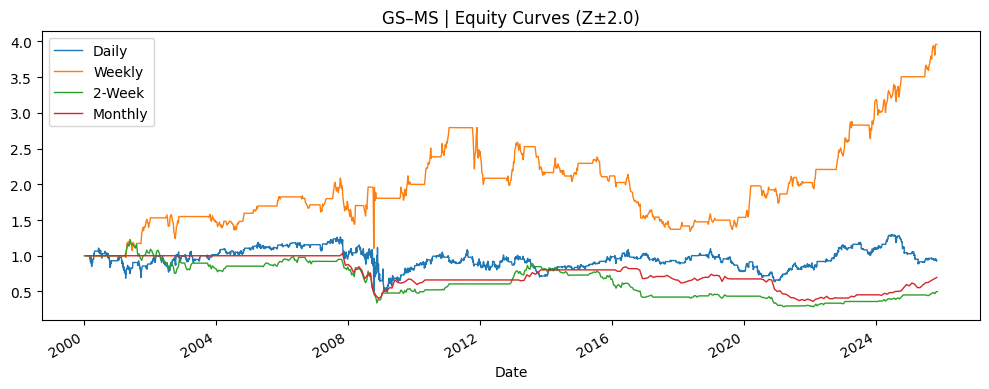

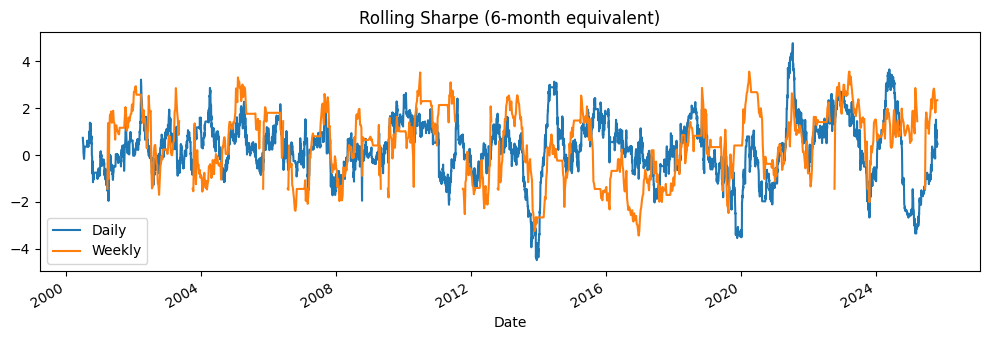

In [26]:
# Compare mean reversion performance
TC_BPS = 5          # round-trip transaction cost in basis points
Z_ENTRY, Z_EXIT = 2.0, 0.0
ZS_WIN = 30

# ===== 1. Download data =====
raw = yf.download(TICKERS, start=START, end=END, auto_adjust=False, progress=False)
prices_d = raw['Adj Close'].dropna().ffill()
prices_w = prices_d.resample('W-FRI').last().dropna()
prices_2w = prices_d.resample('2W-FRI').last().dropna()
prices_m  = prices_d.resample('ME').last().dropna()

# ===== Helper functions =====
def ols_spread(a, b):
    X = sm.add_constant(b)
    model = sm.OLS(a, X, missing='drop').fit()
    alpha, beta = model.params
    spread = a - alpha - beta*b
    return alpha, beta, spread

def zscore(x, win=30):
    m = x.rolling(win, min_periods=win).mean()
    s = x.rolling(win, min_periods=win).std(ddof=0)
    return (x - m) / s

def sharpe_ann(r, periods=252):
    r = r.dropna()
    s = r.std(ddof=0)
    if s == 0 or np.isnan(s):
        return np.nan
    return r.mean() * periods / (s * np.sqrt(periods))

def max_dd(eq):
    peak = eq.cummax()
    dd = eq/peak - 1
    return dd.min()

def backtest(prices, name, tc_bps=5):
    A,B = TICKERS
    a,b = prices[A], prices[B]
    alpha,beta,spread = ols_spread(a,b)

    z = zscore(spread, ZS_WIN)
    
    # trading logic
    pos = pd.Series(0.0, index=prices.index)
    state = 0
    for i in range(len(z)):
        zt = z.iat[i]
        if np.isnan(zt):
            pos.iat[i] = state
            continue
        if state == 0:
            if zt > Z_ENTRY:
                state = -1  # short spread
            elif zt < -Z_ENTRY:
                state = +1  # long spread
        elif (state==1 and zt>=Z_EXIT) or (state==-1 and zt<=Z_EXIT):
            state = 0
        pos.iat[i] = state
    
    # returns of legs
    rA = a.pct_change().fillna(0.0)
    rB = b.pct_change().fillna(0.0)
    
    # --- NORMALIZE BY GROSS NOTIONAL (critical fix) ---
    gross_notional = 1.0 + abs(beta)
    spread_ret = (rA - beta * rB) / gross_notional
    
    # position PnL per $ capital
    gross = pos.shift(1).fillna(0.0) * spread_ret
    
    # transaction costs per $ capital (since wA + wB = 1)
    dpos = pos.diff().abs().fillna(0.0)
    tc = dpos * (TC_BPS * 1e-4)
    
    ret = gross - tc
    eq = (1.0 + ret).cumprod()
    
    # metrics
    periods = {'Daily':252, 'Weekly':52, '2-Week':26, 'Monthly':12}[name]
    sr = sharpe_ann(ret, periods=periods)
    ann = ret.mean()*(periods)
    vol = ret.std(ddof=0)*np.sqrt(periods)
    mdd = max_dd(eq)
    print(f"\n=== {name} Results ===")
    print(f"Sharpe: {sr:.2f} | AnnRet: {ann:.2%} | AnnVol: {vol:.2%} | MaxDD: {mdd:.1%}")
    
    return {"ret":ret, "eq":eq, "z":z, "pos":pos}

# ===== 2. Run backtests =====
bt_d = backtest(prices_d, "Daily", tc_bps=TC_BPS)
bt_w = backtest(prices_w, "Weekly", tc_bps=TC_BPS)
bt_2w = backtest(prices_2w, "2-Week", tc_bps=TC_BPS)
bt_m  = backtest(prices_m,  "Monthly", tc_bps=TC_BPS)

# ===== 3. Plot comparisons =====
plt.figure(figsize=(10,4))
bt_d["eq"].plot(lw=1, label="Daily")
bt_w["eq"].plot(lw=1, label="Weekly")
bt_2w["eq"].plot(lw=1, label="2-Week")
bt_m["eq"].plot(lw=1, label="Monthly")
plt.title(f"{TICKERS[0]}–{TICKERS[1]} | Equity Curves (Z±{Z_ENTRY})")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3.5))
(bt_d["ret"].rolling(126).mean() / bt_d["ret"].rolling(126).std(ddof=0)*np.sqrt(252)).plot(label="Daily")
(bt_w["ret"].rolling(26).mean() / bt_w["ret"].rolling(26).std(ddof=0)*np.sqrt(52)).plot(label="Weekly")
plt.title("Rolling Sharpe (6-month equivalent)")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# Parameter optimization for pairs mean reversion with walk-forward OOS
import numpy as np, pandas as pd, yfinance as yf, statsmodels.api as sm
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# -------- Config --------
TICKERS = ['MS', 'GS']            # or ['MS','GS'] etc.
START   = '2000-01-01'
END     = None
TC_BPS  = 5                        # round-trip bps per $ capital
MIN_TRADES_OOS = 25                # filter too-sparse configs
MAX_TURNOVER_YR = 80               # avg |Δpos| * periods cap (to avoid churny fits)
FREQS = {
    "D":  {"resample": None,       "periods": 252},
    "W":  {"resample": "W-FRI",    "periods": 52},
    # "2W": {"resample": "2W-FRI",   "periods": 26},
    # "M":  {"resample": "M",        "periods": 12},
}

# Search grids (keep moderate first; widen later)
ROLL_WINS  = [60, 90, 126]               # rolling OLS beta window
ZS_WINS    = [20, 30]                    # z window on spread
Z_ENTRIES  = [1.5, 2.0, 2.5]             # entry band
Z_EXITS    = [0.0, 0.25, 0.5]            # soft exit band
HOLD_MAXS  = [3, 5, 7]                   # time-stop (bars)
COOLDOWNS  = [0, 2]                      # bars after close

# Walk-forward splits
TRAIN_YEARS = 5          # first N years train, then expand OOS one year at a time
STEP_YEARS  = 1

# -------- Helpers --------
def rolling_beta(a, b, win):
    idx = a.index.intersection(b.index)
    a, b = a.loc[idx], b.loc[idx]
    mx = b.rolling(win, min_periods=win).mean()
    my = a.rolling(win, min_periods=win).mean()
    cov = (a*b).rolling(win, min_periods=win).mean() - mx*my
    var = (b*b).rolling(win, min_periods=win).mean() - mx*mx
    beta = (cov/var).replace([np.inf, -np.inf], np.nan)
    alpha = my - beta*mx
    return alpha, beta

def backtest_pair(prices, A, B, roll_win, zs_win, z_entry, z_exit, hold_max, cooldown, tc_bps, periods):
    a, b = prices[A], prices[B]
    if len(prices) < max(roll_win, zs_win) + 30:
        return None

    # Rolling hedge
    alpha_t, beta_t = rolling_beta(a, b, roll_win)
    spread = a - alpha_t - beta_t*b
    z = zscore(spread, zs_win)

    # Position logic
    pos = pd.Series(0.0, index=prices.index)
    state, hold, cd = 0, 0, 0
    for i, t in enumerate(prices.index):
        zt = z.iat[i]
        if np.isnan(zt):
            pos.iat[i] = state
            if cd>0: cd-=1
            continue
        if state == 0:
            if cd==0:
                if zt >  z_entry: state, hold = -1, 1
                elif zt < -z_entry: state, hold = +1, 1
        else:
            if (abs(zt) <= z_exit) or (hold >= hold_max):
                state, hold, cd = 0, 0, cooldown
            else:
                hold += 1
        pos.iat[i] = state
        if cd>0: cd-=1

    # Returns per $ capital (normalize by 1+|beta|)
    rA = a.pct_change().fillna(0)
    rB = b.pct_change().fillna(0)
    gross_notional = (1 + beta_t.abs()).fillna(method='ffill').fillna(1.0)
    spread_ret = (rA - beta_t*rB) / gross_notional
    gross = pos.shift(1).fillna(0) * spread_ret

    # Costs per $ capital
    dpos = pos.diff().abs().fillna(0)
    tc = dpos * (tc_bps * 1e-4)

    ret = (gross - tc).dropna()
    if ret.empty: return None

    eq = (1 + ret).cumprod()
    sr = sharpe_ann(ret, periods)
    mdd = max_dd(eq)
    trades = int((dpos>0).sum() / 2)

    # turnover proxy (avg |Δpos| * periods)
    turnover = dpos.mean() * periods
    out = dict(ret=ret, eq=eq, sharpe=sr, mdd=mdd, trades=trades, turnover=turnover)
    return out

def resample_prices(px, key):
    spec = FREQS[key]["resample"]
    if spec is None: 
        return px
    return px.resample(spec).last().dropna()

# -------- Data --------
raw = yf.download(TICKERS, start=START, end=END, auto_adjust=False, progress=False)
pricesD = raw['Adj Close'].ffill().dropna()
assert set(TICKERS).issubset(pricesD.columns)

# Time splits
years = pd.Index(pricesD.index.year.unique())
start_year = years.min() + (TRAIN_YEARS - 1)
splits = []
yr = start_year
while yr < years.max():
    train_end = str(yr) + "-12-31"
    test_end  = str(min(yr + STEP_YEARS, years.max())) + "-12-31"
    splits.append((pricesD.index.min().strftime("%Y-%m-%d"), train_end, test_end))
    yr += STEP_YEARS

# -------- Search --------
records = []
for freq_key in FREQS.keys():
    periods = FREQS[freq_key]["periods"]
    pxF = resample_prices(pricesD, freq_key)

    for roll_win, zs_win, z_entry, z_exit, hold_max, cooldown in product(
        ROLL_WINS, ZS_WINS, Z_ENTRIES, Z_EXITS, HOLD_MAXS, COOLDOWNS
    ):
        oos_rets = []
        oos_trades = 0
        oos_turnover = []
        bad = False

        for train_start, train_end, test_end in splits:
            tr = pxF.loc[train_start:train_end]
            te = pxF.loc[pd.to_datetime(train_end) + pd.offsets.Day(1):test_end]
            if len(tr) < max(roll_win, zs_win) + 50 or len(te) < 20:
                continue

            bt = backtest_pair(pd.concat([tr, te]), TICKERS[0], TICKERS[1],
                               roll_win, zs_win, z_entry, z_exit, hold_max, cooldown,
                               TC_BPS, periods)
            if bt is None:
                bad = True; break

            # only take OOS part
            ret = bt["ret"].loc[te.index.intersection(bt["ret"].index)]
            oos_rets.append(ret)
            oos_trades += bt["trades"]
            oos_turnover.append(bt["turnover"])

        if bad or (not oos_rets):
            continue

        oos = pd.concat(oos_rets).sort_index()
        if oos.empty:
            continue

        sr = sharpe_ann(oos, periods)
        ann = oos.mean()*periods
        vol = oos.std(ddof=0)*np.sqrt(periods)
        eq  = (1+oos).cumprod()
        mdd = max_dd(eq)
        tcount = oos_trades
        tavg = np.nanmean(oos_turnover)

        # filters
        if tcount < MIN_TRADES_OOS: 
            continue
        if tavg > MAX_TURNOVER_YR:
            continue

        records.append({
            "freq": freq_key, "roll_win": roll_win, "zs_win": zs_win,
            "z_entry": z_entry, "z_exit": z_exit, "hold_max": hold_max, "cooldown": cooldown,
            "OOS_Sharpe": sr, "OOS_AnnRet": ann, "OOS_AnnVol": vol, "OOS_MaxDD": mdd,
            "OOS_Trades": tcount, "OOS_TurnoverYr": tavg, "samples": len(oos)
        })

results = pd.DataFrame(records).sort_values("OOS_Sharpe", ascending=False)
print("Top 10 (OOS Sharpe):")
display(results.head(10))

# Stability check: Sharpe by subperiod for best config
if not results.empty:
    best = results.iloc[0]
    print("\nBest config:", best.to_dict())

    # Re-run and show per-split Sharpe
    freq_key = best["freq"]; periods = FREQS[freq_key]["periods"]
    pxF = resample_prices(pricesD, freq_key)
    sub = []
    for train_start, train_end, test_end in splits:
        tr = pxF.loc[train_start:train_end]
        te = pxF.loc[pd.to_datetime(train_end) + pd.offsets.Day(1):test_end]
        bt = backtest_pair(pd.concat([tr, te]), TICKERS[0], TICKERS[1],
                           int(best["roll_win"]), int(best["zs_win"]),
                           float(best["z_entry"]), float(best["z_exit"]),
                           int(best["hold_max"]), int(best["cooldown"]),
                           TC_BPS, periods)
        if bt is None: 
            continue
        oos = bt["ret"].loc[te.index.intersection(bt["ret"].index)]
        sub.append({
            "train_end": train_end,
            "Sharpe": sharpe_ann(oos, periods),
            "AnnRet": oos.mean()*periods,
            "MaxDD": max_dd((1+oos).cumprod()),
            "Trades": bt["trades"],
        })
    sub_df = pd.DataFrame(sub)
    print("\nSubperiod stability for best config:")
    display(sub_df)

Top 10 (OOS Sharpe):


,freq,roll_win,zs_win,z_entry,z_exit,hold_max,cooldown,OOS_Sharpe,OOS_AnnRet,OOS_AnnVol,OOS_MaxDD,OOS_Trades,OOS_TurnoverYr,samples
445,W,90,20,1.5,0.50,3,2,0.564394,0.080822,0.143201,-0.315935,1519,8.702268,1087
432,W,90,20,1.5,0.00,3,0,0.454114,0.070570,0.155402,-0.327853,1704,9.799852,1087
516,W,90,30,2.0,0.50,3,0,0.429036,0.046644,0.108719,-0.208871,746,4.209817,1087
504,W,90,30,2.0,0.00,3,0,0.426861,0.046345,0.108572,-0.208871,735,4.158885,1087
438,W,90,20,1.5,0.25,3,0,0.405564,0.062320,0.153662,-0.328823,1718,9.871206,1087
510,W,90,30,2.0,0.25,3,0,0.400677,0.043319,0.108116,-0.208871,735,4.158885,1087
521,W,90,30,2.0,0.50,7,2,0.390426,0.054789,0.140332,-0.312543,547,3.110200,1087
444,W,90,20,1.5,0.50,3,0,0.385270,0.059044,0.153252,-0.345454,1722,9.886760,1087
520,W,90,30,2.0,0.50,7,0,0.372319,0.053231,0.142970,-0.312543,570,3.218397,1087
433,W,90,20,1.5,0.00,3,2,0.368733,0.053289,0.144520,-0.429409,1457,8.360624,1087



Best config: {'freq': 'W', 'roll_win': 90, 'zs_win': 20, 'z_entry': 1.5, 'z_exit': 0.5, 'hold_max': 3, 'cooldown': 2, 'OOS_Sharpe': 0.5643940150056774, 'OOS_AnnRet': 0.0808219282962977, 'OOS_AnnVol': 0.14320124974302692, 'OOS_MaxDD': -0.3159350449914302, 'OOS_Trades': 1519, 'OOS_TurnoverYr': 8.702268089149996, 'samples': 1087}

Subperiod stability for best config:


,train_end,Sharpe,AnnRet,MaxDD,Trades
0,2004-12-31,0.188816,0.014933,-0.061302,17
1,2005-12-31,0.245427,0.018737,-0.036702,23
2,2006-12-31,-0.086086,-0.014929,-0.189319,30
3,2007-12-31,2.514120,0.658711,-0.044235,36
4,2008-12-31,1.972640,0.453924,-0.053275,41
5,2009-12-31,0.007389,0.001126,-0.119170,45
6,2010-12-31,-0.678044,-0.159602,-0.307948,49
7,2011-12-31,0.236473,0.026053,-0.066484,56
8,2012-12-31,-0.283525,-0.031321,-0.108674,62
9,2013-12-31,0.363552,0.043489,-0.066405,69


In [31]:
def run_oos(freq_key, roll_win, zs_win, z_entry, z_exit, hold_max, cooldown,
            tc_bps=5):
    """
    Run a single walk-forward OOS backtest for the given parameters.
    Returns OOS metrics (Sharpe, AnnRet, AnnVol, MaxDD, Trades, Turnover).
    Uses the same data, splits, and backtest_pair() as in your optimizer.
    """
    from pandas.tseries.offsets import Day

    periods = FREQS[freq_key]["periods"]
    pxF = resample_prices(pricesD, freq_key)

    oos_rets = []
    total_trades = 0
    turnovers = []

    for train_start, train_end, test_end in splits:
        tr = pxF.loc[train_start:train_end]
        te = pxF.loc[pd.to_datetime(train_end) + Day(1):test_end]
        if len(tr) < max(roll_win, zs_win) + 50 or len(te) < 20:
            continue

        bt = backtest_pair(pd.concat([tr, te]), TICKERS[0], TICKERS[1],
                           roll_win, zs_win, z_entry, z_exit,
                           hold_max, cooldown, tc_bps, periods)
        if bt is None:
            continue

        ret = bt["ret"].loc[te.index.intersection(bt["ret"].index)]
        oos_rets.append(ret)
        total_trades += bt["trades"]
        turnovers.append(bt["turnover"])

    if not oos_rets:
        return {"OOS_Sharpe": np.nan, "OOS_AnnRet": np.nan, "OOS_AnnVol": np.nan,
                "OOS_MaxDD": np.nan, "OOS_Trades": 0, "OOS_TurnoverYr": np.nan}

    oos = pd.concat(oos_rets).sort_index()
    sr = sharpe_ann(oos, periods)
    ann = oos.mean()*periods
    vol = oos.std(ddof=0)*np.sqrt(periods)
    eq  = (1+oos).cumprod()
    mdd = max_dd(eq)
    avg_turn = np.nanmean(turnovers)

    return {
        "OOS_Sharpe": sr,
        "OOS_AnnRet": ann,
        "OOS_AnnVol": vol,
        "OOS_MaxDD": mdd,
        "OOS_Trades": total_trades,
        "OOS_TurnoverYr": avg_turn,
        "samples": len(oos)
    }


In [32]:
# Around the best: vary z_entry and z_exit; keep others fixed
grid = []
for z_entry in [1.3, 1.5, 1.7, 2.0]:
    for z_exit in [0.3, 0.5, 0.7]:
        res = run_oos(freq_key="W", roll_win=90, zs_win=20,
                      z_entry=z_entry, z_exit=z_exit,
                      hold_max=3, cooldown=2)   # implement by reusing your backtest over splits
        grid.append({"z_entry":z_entry,"z_exit":z_exit, **res})
pd.DataFrame(grid).sort_values("OOS_Sharpe", ascending=False)

,z_entry,z_exit,OOS_Sharpe,OOS_AnnRet,OOS_AnnVol,OOS_MaxDD,OOS_Trades,OOS_TurnoverYr,samples
4,1.5,0.5,0.564394,0.080822,0.143201,-0.315935,1519,8.702268,1087
1,1.3,0.5,0.463967,0.076388,0.164642,-0.487528,1842,10.457070,1087
3,1.5,0.3,0.353014,0.050243,0.142324,-0.471425,1504,8.638467,1087
5,1.5,0.7,0.338952,0.047984,0.141567,-0.419335,1560,8.942894,1087
0,1.3,0.3,0.324297,0.053610,0.165310,-0.550080,1824,10.380731,1087
2,1.3,0.7,0.289447,0.044630,0.154192,-0.483996,1883,10.647768,1087
7,1.7,0.5,0.249553,0.033570,0.134521,-0.237885,1137,6.425891,1087
10,2.0,0.5,0.235962,0.026755,0.113386,-0.253251,876,5.067099,1087
9,2.0,0.3,0.232203,0.026334,0.113411,-0.259826,876,5.067099,1087
11,2.0,0.7,0.188693,0.021241,0.112567,-0.260702,884,5.101236,1087


In [33]:
rows = []
for tc in [0, 2, 5, 10, 15, 25]:  # bps
    res = run_oos(freq_key="W", roll_win=90, zs_win=20,
                  z_entry=1.5, z_exit=0.5, hold_max=3, cooldown=2, tc_bps=tc)
    rows.append({"tc_bps":tc, **res})
pd.DataFrame(rows)

,tc_bps,OOS_Sharpe,OOS_AnnRet,OOS_AnnVol,OOS_MaxDD,OOS_Trades,OOS_TurnoverYr,samples
0,0,0.600916,0.086108,0.143295,-0.308373,1519,8.702268,1087
1,2,0.586320,0.083994,0.143255,-0.311408,1519,8.702268,1087
2,5,0.564394,0.080822,0.143201,-0.315935,1519,8.702268,1087
3,10,0.527770,0.075536,0.143123,-0.328621,1519,8.702268,1087
4,15,0.491056,0.070250,0.143059,-0.351678,1519,8.702268,1087
5,25,0.417399,0.059677,0.142975,-0.397551,1519,8.702268,1087


Full-series (W) — Sharpe=0.51, MaxDD=-31.6%, AnnRet=6.92%


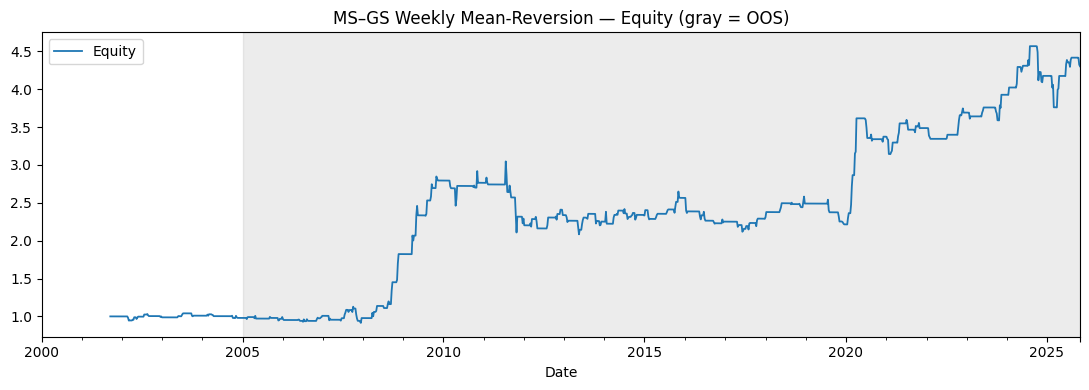

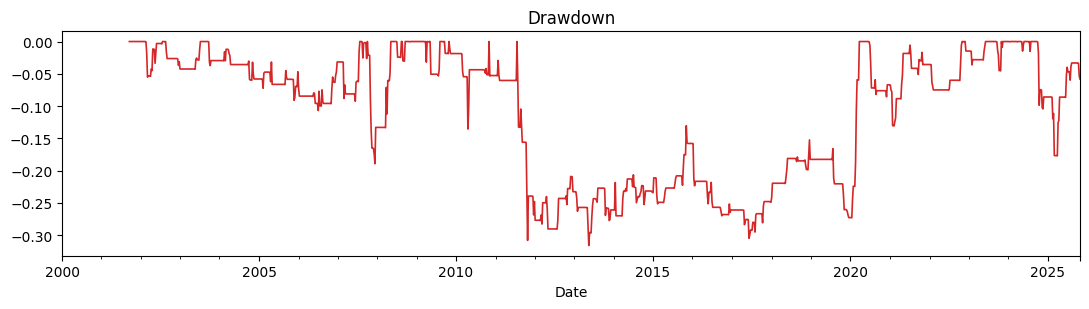

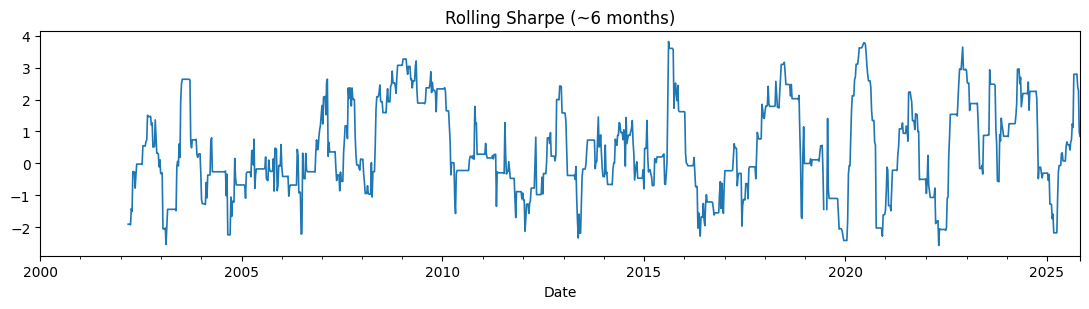

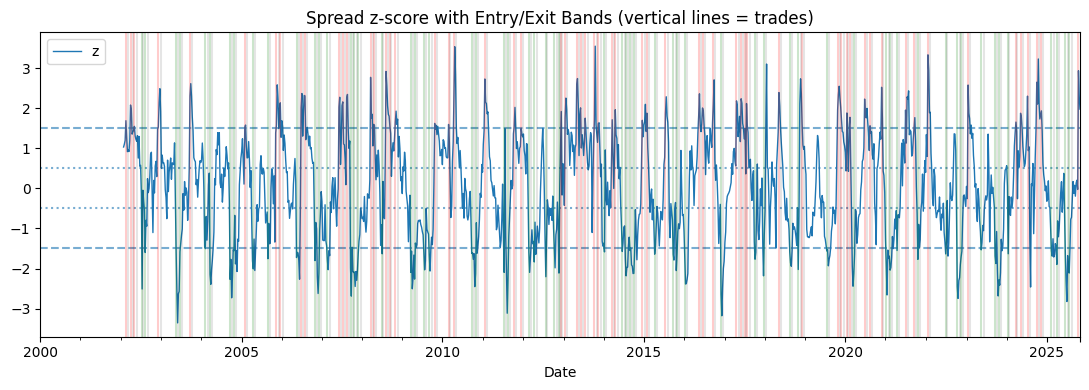

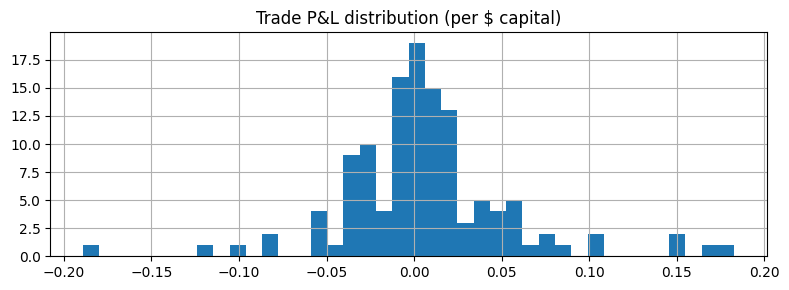

OOS-only — Sharpe=0.56, MaxDD=-31.6%, AnnRet=8.08%


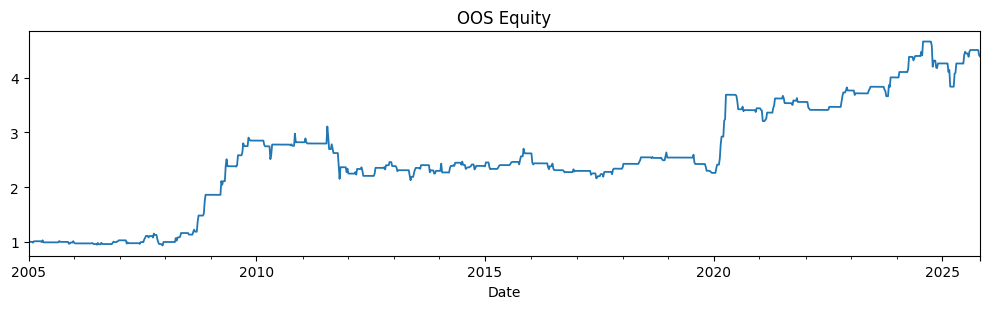

In [34]:
BEST = dict(freq='W', roll_win=90, zs_win=20, z_entry=1.5, z_exit=0.5,
            hold_max=3, cooldown=2, tc_bps=5)

periods = FREQS[BEST['freq']]["periods"]
pxF = resample_prices(pricesD, BEST['freq'])
A, B = TICKERS

# --- helpers tailored for this cell ---
def rolling_beta_alpha(a, b, win):
    mx = b.rolling(win, min_periods=win).mean()
    my = a.rolling(win, min_periods=win).mean()
    cov = (a*b).rolling(win, min_periods=win).mean() - mx*my
    var = (b*b).rolling(win, min_periods=win).mean() - mx*mx
    beta  = (cov/var).replace([np.inf, -np.inf], np.nan)
    alpha = my - beta*mx
    return alpha, beta

def dd_series(eq):
    peak = eq.cummax()
    return eq/peak - 1.0

# --- build full-series backtest with detailed outputs (pos, z, trades) ---
a, b = pxF[A], pxF[B]
alpha_t, beta_t = rolling_beta_alpha(a, b, BEST['roll_win'])
spread = a - alpha_t - beta_t*b
z = zscore(spread, BEST['zs_win'])

pos = pd.Series(0.0, index=pxF.index)
state = 0; hold = 0; cd = 0
entries, exits = [], []
for i, t in enumerate(pxF.index):
    zt = z.iat[i]
    if np.isnan(zt):
        pos.iat[i] = state
        cd = max(0, cd-1)
        continue
    if state == 0:
        if cd == 0:
            if zt >  BEST['z_entry']:
                state, hold = -1, 1; entries.append((t, -1))
            elif zt < -BEST['z_entry']:
                state, hold = +1, 1; entries.append((t, +1))
    else:
        if (abs(zt) <= BEST['z_exit']) or (hold >= BEST['hold_max']):
            exits.append((t, state)); state, hold, cd = 0, 0, BEST['cooldown']
        else:
            hold += 1
    pos.iat[i] = state
    cd = max(0, cd-1)

# per-$ capital return (normalize by 1+|beta|)
rA = a.pct_change().fillna(0.0)
rB = b.pct_change().fillna(0.0)
gross_notional = (1.0 + beta_t.abs()).fillna(method='ffill').fillna(1.0)
spread_ret = (rA - beta_t*rB) / gross_notional

dpos = pos.diff().abs().fillna(0.0)
tc = dpos * (BEST['tc_bps'] * 1e-4)
ret = (pos.shift(1).fillna(0.0) * spread_ret) - tc
eq  = (1.0 + ret).cumprod()
dd  = dd_series(eq)
sr  = sharpe_ann(ret, periods)

print(f"Full-series ({BEST['freq']}) — Sharpe={sr:.2f}, MaxDD={dd.min():.1%}, AnnRet={ret.mean()*periods:.2%}")

# --- build OOS mask from your splits for shading ---
from pandas.tseries.offsets import Day
oos_mask = pd.Series(False, index=pxF.index)
for train_start, train_end, test_end in splits:
    te = pxF.loc[pd.to_datetime(train_end) + Day(1): test_end]
    oos_mask.loc[te.index] = True

# --- extract trade P&L distribution (entry→exit cumulative return) ---
# approximate by summing returns between sign changes or flat resets
trades = []
current_sign = 0; cumret = 0.0; start_t = None
for t in ret.index:
    sgn = pos.loc[t]
    if current_sign == 0 and sgn != 0:
        current_sign = sgn; cumret = 0.0; start_t = t
    elif current_sign != 0 and sgn == 0:
        trades.append({"start": start_t, "end": t, "ret": cumret})
        current_sign = 0; start_t = None; cumret = 0.0
    if current_sign != 0:
        cumret += ret.loc[t]
trades_df = pd.DataFrame(trades)

# ================== PLOTS ==================
plt.figure(figsize=(11,4))
eq.plot(lw=1.3, label='Equity')
# Shade OOS regions
in_oos = False; x0 = None
for t, flag in oos_mask.items():
    if flag and not in_oos: in_oos = True; x0 = t
    if not flag and in_oos: 
        plt.axvspan(x0, t, color='gray', alpha=0.15)
        in_oos = False
if in_oos: plt.axvspan(x0, eq.index[-1], color='gray', alpha=0.15)
plt.title(f"{A}–{B} Weekly Mean-Reversion — Equity (gray = OOS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,3.2))
dd.plot(lw=1.2, color='tab:red')
plt.title("Drawdown"); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,3.2))
roll = { 'D':126, 'W':26, '2W':13, 'M':12 }[BEST['freq']]
rs = (ret.rolling(roll).mean() / ret.rolling(roll).std(ddof=0)) * np.sqrt(periods)
rs.plot(lw=1.2)
plt.title(f"Rolling Sharpe (~6 months)"); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,4))
z.plot(lw=1, label='z')
plt.axhline(BEST['z_entry'],  ls='--', alpha=0.6)
plt.axhline(-BEST['z_entry'], ls='--', alpha=0.6)
plt.axhline(BEST['z_exit'],   ls=':',  alpha=0.6)
plt.axhline(-BEST['z_exit'],  ls=':',  alpha=0.6)
# mark entries/exits
for t, s in entries:
    plt.axvline(t, color='green' if s>0 else 'red', alpha=0.2)
for t, s in exits:
    plt.axvline(t, color='black', alpha=0.1)
plt.title("Spread z-score with Entry/Exit Bands (vertical lines = trades)")
plt.legend(); plt.tight_layout(); plt.show()

if not trades_df.empty:
    plt.figure(figsize=(8,3))
    trades_df['ret'].hist(bins=40)
    plt.title("Trade P&L distribution (per $ capital)"); plt.tight_layout(); plt.show()

# OOS-only equity
oos_ret = ret[oos_mask]
oos_eq  = (1+oos_ret).cumprod()
print(f"OOS-only — Sharpe={sharpe_ann(oos_ret, periods):.2f}, MaxDD={(oos_eq/oos_eq.cummax()-1).min():.1%}, AnnRet={oos_ret.mean()*periods:.2%}")
plt.figure(figsize=(10,3.2))
oos_eq.plot(lw=1.3)
plt.title("OOS Equity"); plt.tight_layout(); plt.show()
